# Phase Diagram of the Quark-Meson Model using the Finite-Difference Method


---
*Author: Phillip Lakaschus*

# Coding the solver


---

In [1]:
!pip install findiff==0.7.0  

# Import libraries
import time
import numpy as np                  # needed for efficient array manipulation
import matplotlib.pyplot as plt     # plot library
from scipy.integrate import solve_ivp  # import the time integrator
from scipy import integrate         
from findiff import FinDiff         # finite difference library              

Let's define all functions that are needed for the flow equation:

In [2]:
def Esig(x, ux, uxx, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*ux + 4*x*uxx)

def Epion(ux, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*ux)

def Epsi(x, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + h**2*x)

def pion_mass(u, min_pos):
  m_pi = np.sqrt(2*d_dx(u)[min_pos])*cutoff
  return m_pi

def sigma_mass(xc, u, min_pos):
  m_sigma = np.sqrt(2*d_dx(u)[min_pos] + 4*x[min_pos]*d2_dx2(u)[min_pos])*cutoff
  return m_sigma

Eq. (1) which needs to be integrated:

In [3]:
def dudt(u, t, T, mu):
  """ u is a N-dimensional vector where the i-th component corresponds to the i-th grid point """
  ux = d_dx(u)      # Discrete derivative ux[i] = (u[i+1] - u[i])/dx = c; ux[-1] = (u[-1] - u[-2])/dx
  uxx = d2_dx2(u)   
  Ep = Epion(ux, t)
  Es = Esig(x, ux, uxx, t)
  Eq = Epsi(x, t)
  dudt = -cutoffr**5*np.exp(-5*t)/(12*np.pi**2)*( 3.0/Ep*(1.0/np.tanh(Ep/(2*T)))
                          + 1.0/(Es)*(1.0/np.tanh(Es/(2*T)))
                          - 12.0/Eq*(np.tanh((Eq - mu)/ (2*T))
                          + np.tanh((Eq + mu)/(2*T))) )
  return dudt

def solve(T, mu):
  """ Here the ODE Solver is called, for documentation see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html"""
  print((T, mu))
  return solve_ivp(lambda t, y: dudt(y, t, T, mu), (t[0], t[-1]), v0, method='BDF', t_eval = t, rtol=1e-13, atol=1e-13).y.T

In [4]:
# All quantities are rendered dimensionless with respect to the cutoff
cutoff = 1000
cutoffr = 1  # rescaled cutoff; Set cutoffr = 1000 and cutoff = 1 for dimensionful calculation
  
N = 60 # number of gridpoints
xmax = 140**2/cutoff**2 # Grid extent
x = np.linspace(0, xmax, N) # grid
N_t = 100
t_max = 3.5 # This corresponds to roughly k = 30 MeV; k_IR = cutoff*np.exp(-t_max)
t = np.linspace(0, t_max, N_t)
dx = x[1] - x[0]
  
# define derivatives
# https://github.com/maroba/findiff
acc = 2
d_dx = FinDiff(0, dx, acc = acc)
d2_dx2 = FinDiff(0, dx, 2, acc = acc)

# Model parameters
m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from https://arxiv.org/abs/1311.0630

v0 = (1.0/2.0*m_lam**2*x + lam/4.0*x**2) # initial effective potential
expl_sym_br = c*np.sqrt(x) # c*sigma # explicit symmetry breaking term: Does not contribute to the flow equation but will be added to the IR effective potential

# cost function = (fpi - 93)^2 + (mpi - 140)^2

Plot UV potential

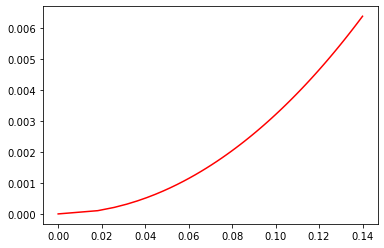

In [5]:
plt.plot(np.sqrt(x), v0, color="red")
plt.show()

Now let's solve the flow equation for $T = 5$ MeV and $\mu = 0$.

In [6]:
start = time.time()  
T, mu = 5/cutoff, 0/cutoff
sol_example = solve(T, mu)

print("Duration: "+str(time.time()-start)[:2]+" s")

(0.005, 0.0)
Duration: 0. s


In [7]:
"""Taken from https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2"""
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( 0, 0.12))
#ax.set_ylim((-0.0001, 0.00021))
ax.set_ylim((-0.001, 0.0025))
line2, = ax.plot([], [], lw=2)

# animation function: this is called sequentially
def animate(i):
  # Ich ziehe hier immer den Wert am Ursprung ab, damit das Potential immer bei 0 im Urpsrung ist
  # Das macht es einfacher zu plotten.
  line2.set_data(np.sqrt(x), sol_example[i] - sol_example[i][0]) 
  return (line2,)

anim = animation.FuncAnimation(fig, animate, frames=N_t, blit=True)

rc('animation', html='jshtml')
anim

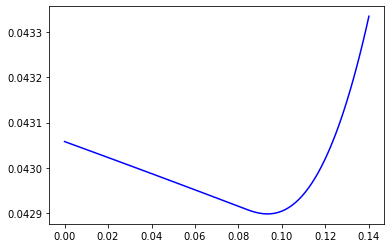

Minimum of the potential:  92.93701165624609
Pion mass:  133.05924726519333
Sigma mass:  504.3703342804395


In [8]:
plt.plot(np.sqrt(x), sol_example[-1] - expl_sym_br, c='b')
plt.show()
u = sol_example[-1] - sol_example[-1][0]
min_pos = np.argmin(u - expl_sym_br)
f_pi = np.sqrt(min_pos*dx)*cutoff
m_pi = pion_mass(u, min_pos)
m_sig = sigma_mass(x, u, min_pos)
print("Minimum of the potential: ", f_pi)
print("Pion mass: ", m_pi)
print("Sigma mass: ", m_sig)

# Differential Evolution

In [ ]:
from scipy.optimize import differential_evolution

def cost(params):
  global v0, m_lam, lam
  m_lam, lam = params
  print("m_lam, lam, c: ", m_lam*cutoff, lam, c*cutoff**3)
  v0 = (1.0/2.0*m_lam**2*x + lam/4.0*x**2)
  sol = solve(5/cutoff, 0/cutoff)[-1]
  expl_sym_br = c*np.sqrt(x)
  min_pos = np.argmin(sol - expl_sym_br)
  f_pi, m_pi, m_sig = np.sqrt(min_pos*dx)*cutoff, pion_mass(sol, min_pos), sigma_mass(x, sol, min_pos)
  print("fpi, mpi, msig: ", (f_pi, m_pi, m_sig))
  # Sigma masse durch einen großen Wert teilen, weil diese nicht genau bekannt ist. 
  # Wichtiger ist es, fpi und mpi genau zu bestimmen.
  return ((f_pi - 93.3)/(1))**2 + ((m_pi - 138)/(2))**2 + ((m_sig - 516)/(100))**2 

def diff_evo():
  m_lam_min, m_lam_max = 700/cutoff, 1000/cutoff
  lam_min, lam_max = 0.001, 5
  bounds = [(m_lam_min, m_lam_max), (lam_min, lam_max)]
  result = differential_evolution(cost, bounds)
  return result

diff_evo()

m_lam, lam, c:  870.879614423505 3.5622935983153683 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (60.45028774237218, 173.32487620101722, 442.7639207968517)
m_lam, lam, c:  895.3452915202669 0.43741795803147676 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (60.45028774237218, 182.3322949796967, 439.03559228339594)
m_lam, lam, c:  927.7537682662033 4.679627032336761 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (36.45289507463068, 206.6000958153225, 368.59641706159323)
m_lam, lam, c:  775.1198329040869 1.2957347631433167 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (104.70296970194674, 136.70985776233718, 531.4296031566014)
m_lam, lam, c:  852.978130279178 4.850043996030886 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (63.13826635223763, 166.4874191007944, 451.4368068298928)
m_lam, lam, c:  955.5373565701785 0.7381089549005924 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  (36.45289507463068, 232.8848141975332, 383.2496491807774)
m_lam, lam, c:  842.9704080940949 4.528863105899815 1750000.0
(0.005, 0.0)
fpi, mpi, msig:  

KeyboardInterrupt: ignored

Computation takes some time, can be interrupted whenever suitable parameters are found.

# Phase diagram of the QMM

**Warning:** Calculation of the phase diagram takes about an hour!

In [ ]:
  # Calculate phase diagram
  from joblib import Parallel, delayed
  import multiprocessing

  T_min, T_max = 5/cutoff, 120/cutoff
  mu_min, mu_max = 0/cutoff, 310/cutoff
  N_T, N_mu = 10, 10

  T_array = np.linspace(T_min, T_max, N_T)
  mu_array = np.linspace(mu_min, mu_max, N_mu)
  mu_ax, T_ax = np.meshgrid(mu_array, T_array)

  sol = [[None for _ in range(N_mu)] for _ in range(N_T)]
  min_values, m_sig, m_pi = np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu])

  num_cores = multiprocessing.cpu_count()
  print("number of cores: ", num_cores)
  start = time.time()  
  for i in range(N_T):
    sol[i] = Parallel(n_jobs=num_cores)(delayed(solve)(T_array[i], mu_array[j]) for j in range(N_mu))
  print("Duration: "+str(time.time()-start)[:6]+" s")

number of cores:  2
Duration: 99.436 s


Interpolate IR Potential for more precise determination of the minimimum and calculate masses:

In [ ]:
  from scipy.interpolate import InterpolatedUnivariateSpline as ius

  for i in range(N_T):
    for j in range(N_mu):
      s = sol[i][j][-1] - expl_sym_br
      #print(s)
      spl = ius(x, s, k=4)
      cr_pts = spl.derivative().roots()
      cr_pts = np.append(cr_pts, (x[0], x[-1]))
      cr_vals = spl(cr_pts)
      min_index = cr_pts[np.argmin(cr_vals)]
      min_values[i, j] = np.sqrt(min_index)
      s2 = sol[i][j][-1]
      spl2 = ius(x, s2, k=5)
      m_pi[i, j] = np.sqrt(c/min_values[i, j])
      spl_der = spl2.derivative(n=2)
      m_sig[i, j] = np.sqrt(4*min_values[i, j]**2*spl_der(min_index) + m_pi[i, j]**2)
      #rint("(T, mu, fpi): "+str((T_array[i], mu_array[j], min_values[i, j]*cutoff)))

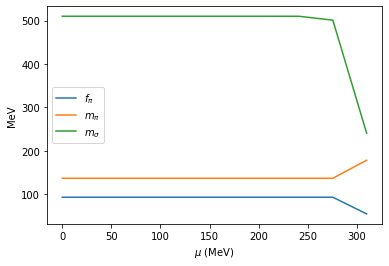

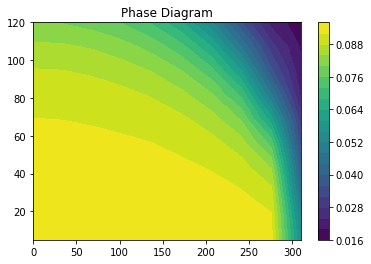

In [ ]:
  # plot results
  from matplotlib.ticker import MaxNLocator
  fig, ax = plt.subplots()
  ax.plot(mu_array*cutoff, min_values[0, :]*cutoff, label='$f_\pi$')
  ax.plot(mu_array*cutoff, m_pi[0, :]*cutoff, label='$m_\pi$')
  ax.plot(mu_array*cutoff, m_sig[0, :]*cutoff, label='$m_\sigma$')
  leg = ax.legend()
  ax.set_ylabel('MeV')
  ax.set_xlabel('$\mu$ (MeV)')
  plt.show()

  mu_ax, T_ax = np.meshgrid(mu_array*cutoff, T_array*cutoff)
  fig, ax1 = plt.subplots(nrows=1)
  min_vals = min_values
  levels = MaxNLocator(nbins=20).tick_values(min_vals.min(),
                                                min_vals.max())
  CS = ax1.contourf(mu_ax, T_ax, min_values, levels=levels)
  fig.colorbar(CS, ax=ax1)
  plt.title('Phase Diagram')
  plt.show()